In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from google.colab import drive

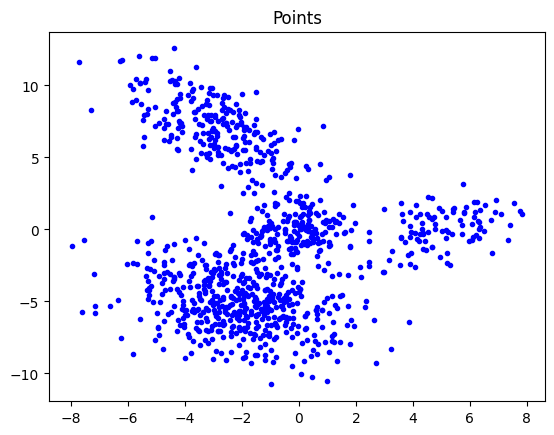

In [ ]:
file_path = '/content/drive/MyDrive/KRR/GMM.in'

with open(file_path, 'r') as file:
    lines = file.readlines()

points = [list(map(float, line.strip().split())) for line in lines]
data = points_array = np.array(points)

x_values=data[:,0]
y_values=data[:,1]

plt.scatter(x_values, y_values, marker='.', color='blue', label='Points')
plt.title("Points")
plt.show()

In [ ]:
def get_initial_data(data,nr_clusters):
  min_values = np.min(data, axis=0)
  max_values = np.max(data, axis=0)
  initial_means = np.random.uniform(min_values, max_values, size=(nr_clusters, 2))

  data_covariance = np.cov(data, rowvar=False)
  initial_covariances = np.tile(data_covariance, (nr_clusters, 1, 1))

  initial_weights = np.ones(nr_clusters) / nr_clusters

  return initial_means, initial_covariances, initial_weights

In [ ]:
initial_means, initial_covariances, initial_weights=get_initial_data(data,4)
print(f'Initial means: {initial_means}')
print(f'Initial covariances: {initial_covariances}')
print(f'Initial weights: {initial_weights}')

Initial means: [[-1.1448181   3.23429012]
 [-6.50751052 -2.9825629 ]
 [-4.88479249  4.30830986]
 [ 6.13914471 -0.54627537]]
Initial covariances: [[[ 7.81704807 -1.62501601]
  [-1.62501601 27.51152949]]

 [[ 7.81704807 -1.62501601]
  [-1.62501601 27.51152949]]

 [[ 7.81704807 -1.62501601]
  [-1.62501601 27.51152949]]

 [[ 7.81704807 -1.62501601]
  [-1.62501601 27.51152949]]]
Initial weights: [0.25 0.25 0.25 0.25]


In [ ]:
def compute_multivariate_pdf(point, mean, covariance):
  det_covariance = np.linalg.det(covariance)
  inv_covariance = np.linalg.inv(covariance)

  exponent = -0.5 * np.dot(np.dot((point - mean).T, inv_covariance), (point - mean))
  coefficient = 1 / np.sqrt((2 * np.pi) ** covariance.shape[0] * det_covariance)

  return coefficient * np.exp(exponent)

In [ ]:
def compute_loglikelihood(data, means, covariances, weights):
    log_likelihood = 0

    nr_points=len(data)
    nr_clusters=len(weights)

    for i in range(nr_points):
        likelihood_sum = 0
        for k in range(nr_clusters):
            component_likelihood = weights[k] * compute_multivariate_pdf(data[i], means[k], covariances[k])

            likelihood_sum += component_likelihood

        log_likelihood += np.log(likelihood_sum)

    return log_likelihood


In [ ]:
def compute_weights(membership_weights):
  nr_points, nr_clusters=membership_weights.shape
  weights=np.sum(membership_weights, axis=0)/nr_points

  return weights

In [ ]:
def compute_means(membership_weights):
   nr_points, nr_clusters = membership_weights.shape
   dimensionality = len(data[0])

   means = np.zeros((nr_clusters, dimensionality))

   for k in range(nr_clusters):
      sum_weighted_points = np.sum(membership_weights[:, k][:, np.newaxis] * data, axis=0)
      sum_weights = np.sum(membership_weights[:, k])
      means[k, :] = sum_weighted_points / sum_weights if sum_weights != 0 else np.zeros(dimensionality)

   return means

In [ ]:
def compute_covariances(membership_weights, means):
   nr_points, nr_clusters = membership_weights.shape
   dimensionality = len(data[0])

   covariances=[]

   for k in range(nr_clusters):
        sum_weighted_outer_products = np.zeros((dimensionality, dimensionality))

        for i in range(nr_points):
            diff = data[i] - means[k]
            outer_product = np.outer(diff, diff)
            sum_weighted_outer_products += membership_weights[i, k] * outer_product

        sum_weights = np.sum(membership_weights[:, k])

        covariance = sum_weighted_outer_products / sum_weights if sum_weights != 0 else np.eye(dimensionality)
        covariances.append(covariance)

   return covariances

In [ ]:
def expectation_step(data, means, covariances, weights):
  nr_points=len(data)
  nr_clusters=len(weights)

  membership_weights=np.zeros((nr_points,nr_clusters))

  for i in range(nr_points):
    for k in range(nr_clusters):
        membership_weights[i,k]=compute_multivariate_pdf(data[i],means[k],covariances[k]) * weights[k]

  row_sums=membership_weights.sum(axis=1)[:, np.newaxis]
  membership_weights=membership_weights/row_sums

  return membership_weights

In [ ]:
def expectation_maximization(data, initial_means, initial_covariances, initial_weights, maxiter=1000, threshold=1e-5, verbose=True):

    nr_clusters=len(initial_weights)
    nr_points=len(data)

    means = initial_means[:]
    covariances = initial_covariances[:]
    weights = initial_weights[:]

    loglikelihoods=[]
    prev_loglikelihood=float('-inf')

    for iteration in range(maxiter):
        print(f"Current iteration {iteration}")

        membership_weights = expectation_step(data, means, covariances, weights)

        weights = compute_weights(membership_weights)
        means = compute_means(membership_weights)
        covariances = compute_covariances(membership_weights, means)

        loglikelihood = compute_loglikelihood(data, means, covariances, weights)
        loglikelihoods.append(loglikelihood)
        if (loglikelihood - prev_loglikelihood) < threshold:
            break

        prev_loglikelihood = loglikelihood


    return means, covariances, weights, loglikelihoods, membership_weights

In [ ]:
def plot_clusters(data, membership_weights):
    cluster_assignments = np.argmax(membership_weights, axis=1)

    plt.figure(figsize=(8, 6))

    for cluster in range(membership_weights.shape[1]):
        cluster_points = data[cluster_assignments == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster + 1}')

    plt.title('Clustered Scatter Plot')
    plt.legend()
    plt.show()


In [ ]:
means, covariances, weights, loglikelihoods, memberships=expectation_maximization(data, initial_means, initial_covariances, initial_weights)

Current iteration 0
Current iteration 1
Current iteration 2
Current iteration 3
Current iteration 4
Current iteration 5
Current iteration 6
Current iteration 7
Current iteration 8
Current iteration 9
Current iteration 10
Current iteration 11
Current iteration 12
Current iteration 13
Current iteration 14
Current iteration 15
Current iteration 16
Current iteration 17
Current iteration 18
Current iteration 19
Current iteration 20
Current iteration 21
Current iteration 22
Current iteration 23
Current iteration 24
Current iteration 25
Current iteration 26
Current iteration 27
Current iteration 28
Current iteration 29
Current iteration 30
Current iteration 31
Current iteration 32
Current iteration 33
Current iteration 34
Current iteration 35
Current iteration 36
Current iteration 37
Current iteration 38
Current iteration 39
Current iteration 40
Current iteration 41
Current iteration 42
Current iteration 43


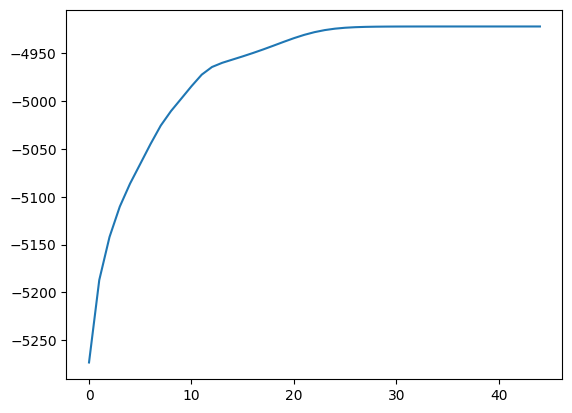

In [ ]:
plt.plot(loglikelihoods)
plt.show()

In [ ]:
for i in range(len(weights)):
  print(f'Cluster {i+1}')
  print(f'Mean: {np.round(means[i],3)}')
  print(f'Covariance:{np.round(covariances[i],3)}')
  print(f'Weight:{np.round(weights[i],3)}')
  print()

Cluster 1
Mean: [-0.098 -0.062]
Covariance:[[0.874 0.1  ]
 [0.1   1.122]]
Weight:0.163

Cluster 2
Mean: [-2.103 -5.124]
Covariance:[[ 3.689 -1.106]
 [-1.106  4.06 ]]
Weight:0.495

Cluster 3
Mean: [-2.858  6.935]
Covariance:[[ 2.682 -2.437]
 [-2.437  4.843]]
Weight:0.243

Cluster 4
Mean: [ 4.936 -0.027]
Covariance:[[1.824 0.858]
 [0.858 1.889]]
Weight:0.099



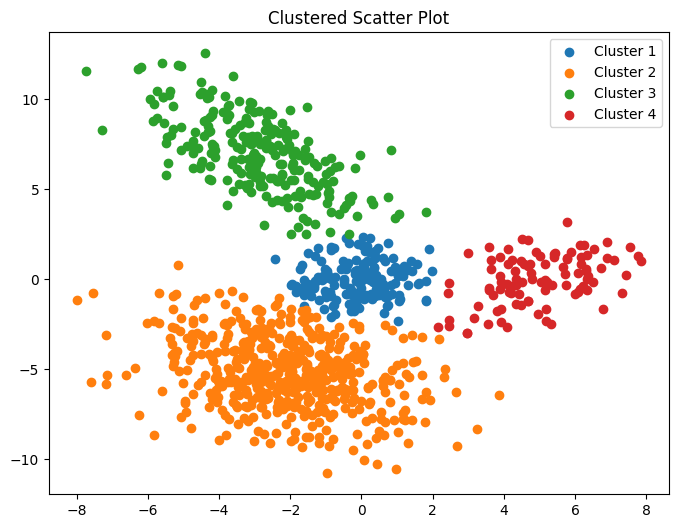

In [ ]:
plot_clusters(data, memberships)